Box Model from SEAWAT Henry Problem Example
https://github.com/modflowpy/flopy/blob/develop/examples/Notebooks/flopy3_SEAWAT_henry_problem.ipynb

Treat left flux boundary as injection well. 
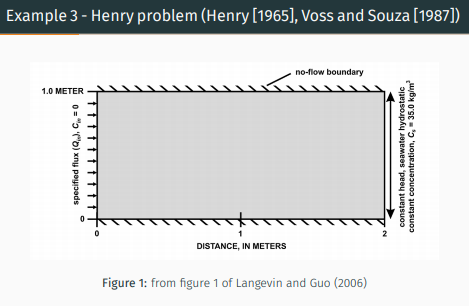
https://www2.hawaii.edu/~jonghyun/classes/S18/CEE696/files/12_flopy_seawat.pdf

In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt

# run installed version of flopy or add local path
try:
    import flopy
except:
    fpth = os.path.abspath(os.path.join('..', '..'))
    sys.path.append(fpth)
    import flopy

print(sys.version)
print('numpy version: {}'.format(np.__version__))
print('flopy version: {}'.format(flopy.__version__))

flopy is installed in C:\ProgramData\Anaconda3\lib\site-packages\flopy
3.7.3 (default, Mar 27 2019, 17:13:21) [MSC v.1915 64 bit (AMD64)]
numpy version: 1.16.2
flopy version: 3.2.12


In [2]:
name = 'SeawatBoxModel'
workspace = 'D:/Chelsea/Projects/DelawareStream/FloPy/' + name
if not os.path.exists(workspace):
    os.makedirs(workspace)
exe_name = os.path.abspath('D:/Chelsea/Projects/DelawareStream/Script/Executables/swtv4')

In [176]:
# All inputs
len_units = 'meters'
time_units = 'days'

# Grid
Lx = 100. #total width across rows of entire model
Ly = 500. #total width across columns
ztop = 1. #top elevation of layer 1
zbot = -49. #bottom elevation
nlay = 10 #number of layers
nrow = 50 #number of rows
ncol = 5 #number of columns
Lz = ztop-zbot #total depth
delr = Lx / ncol #the cell width along rows
delc = Ly / nrow #the cell width along columns
delv = Lz / nlay #elevation change from top to bottom of model
henry_botm = np.linspace(ztop - delv, zbot, nlay) #bottom of each layer

# Flow
hk = 864.  #m/day hydraulic conductivity
laycbd = 0 #Flags indicating whether or not a layer has a Quasi-3D confining bed below it. 0 indicates no confining bed, and not zero indicates a confining bed. 

# Time 
nper = 1 #stress periods per simulation
perlen = 50 #days, length of stress period
nstp =  perlen #number of time steps of a stress period

# Boundaries
ibound = np.ones((nlay, nrow, ncol), dtype=np.int32) #boundary variable... one value for every cell... if >0 cell is active, if =0 cell is inactive, if <0 cell has constant head. 
ibound[:, -1, :] = -1 # set the constant head cell at the boundary
ibound[:, 0, :] = 1 # set the constant head cell at the boundary
strt = 0 #initial starting head... one value for every cell

# save cell fluxes to unit 53
ipakcb = 53

#Criteria for Convergence
hclose = 1e-4# 1.e-8 #head change criterion for convergence.

###########################################################################################################
# Transport
dmcoef = 0.57024 #m2/day  Could also try 1.62925 as another case of the Henry problem. DMCOEF is used in MT3D as the effective molecular diffusion coefficient.
prsity = 0.35 #porosity
al = 0. #longitudinal dispersivity, L
trpt = 1. #ratio of transverse to longitudinal dispersivity
sconc = 35. #starting concentration

# Advection
mixelm = 0 # integer flag for the advection solution option, = 0, the standard finite-difference method with upstream or central-in-space weighting
nprs=-5 #A flag indicating (i) the frequency of the output and (ii) whether the output frequency is specified in terms of total elapsed simulation time or the transport step number. 
ifmtcn=0 #A flag/format code indicating how the calculated concentration should be printed to the standard output text file.
chkmas=True #A logical flag indicating whether a one-line summary of mass balance information should be printed.
nprobs=10 #An integer indicating how frequently the concentration at the specified observation points should be saved. 
nprmas=10 #An integer indicating how frequently the mass budget information should be saved. 
dt0=0.01 #0.001 #The user-specified initial transport step size within each time-step of the flow solution. 
trpv=1. # is the ratio of the vertical transverse dispersivity to the longitudinal dispersivity.  
iter1 = 500 #500 #max num of inner iterations
mxiter = 1 #max num of outer iterations
isolve=1 #type of preconditioners to be used with the Lanczos/ORTHOMIN acceleration scheme: = 1, Jacobi = 2, SSOR = 3 
cclose=1e-4 #1e-7 #convergence criterion in terms of relative concentration; a real value between 10-4 and 10-6 is generally adequate.
 
# Variable Density 
iwtable=0 #flag for variable-density water-table corrections (Guo and Langevin, 2002, eq. 82). If IWTABLE = 0, the water-table correction will not be applied. If IWTABLE > 0, the water-table correction will be applied.
densemin=0 #minimum fluid density
densemax=0 #maximum fluid density
denseref=1000. #fluid density at the reference conc, temp, and press. For most simulations, DENSEREF is specified as the density of freshwater at 25 degrees C and at a reference pressure of zero.
denseslp=0.7143 #slope of the linear equation of state that relates fluid density to solute concentration
firstdt=1e-3 #length of the first transport timestep used to start the simulation if both of the following two conditions are met: 1. The IMT Process is active, and 2. transport timesteps are calculated as a function of the user-specified Courant number (the MT3DMS input variable, PERCEL, is greater than zero).

# Create WEL and SSM data
itype = flopy.mt3d.Mt3dSsm.itype_dict()
wel_data = {}
ssm_data = {}
wel_sp1 = []
ssm_sp1 = []
qinflow = 50.72#5.702  #m3/day
for ik in range(ncol):
    for k in range(nlay):
        wel_sp1.append([k, 0, ik, qinflow / nlay]) #layer, row, col, flux
        ssm_sp1.append([k, 0, ik, 0., itype['WEL']]) #layer, row, col, starting concentration, type of cell
        ssm_sp1.append([k, nrow-1, ik, sconc, itype['BAS6']]) # for all other cells start with seawater conc
#If the BAS6 Package is used to specify constant-head cells, the initial head is converted to a reference head using the
#initial fluid density array, and this reference head value remains constant during the simulation.
        wel_sp1.append([k, nrow-15, ncol-2, -qinflow/20]) #layer, row, col, flux
wel_data[0] = wel_sp1
ssm_data[0] = ssm_sp1

In [177]:
# Create the basic MODFLOW model structure
modelname = name
swt = flopy.seawat.Seawat(modelname, exe_name=exe_name, model_ws=workspace)
print(swt.namefile)

# Add DIS package to the MODFLOW model
dis = flopy.modflow.ModflowDis(swt, nlay, nrow, ncol, nper=nper, delr=delr,
                               delc=delc, laycbd=laycbd, top=ztop,
                               botm=henry_botm, perlen=perlen, nstp=nstp)

# BAS package
bas = flopy.modflow.ModflowBas(swt, ibound, strt)

# Add LPF package to the MODFLOW model
lpf = flopy.modflow.ModflowLpf(swt, hk=hk, vka=hk, ipakcb=ipakcb)

# Add PCG Package to the MODFLOW model
pcg = flopy.modflow.ModflowPcg(swt, hclose=hclose)

# Add OC package to the MODFLOW model
oc = flopy.modflow.ModflowOc(swt, 
                             stress_period_data={(0, 0): ['save head', 'save budget']},
                             compact=True)

#Wells
wel = flopy.modflow.ModflowWel(swt, stress_period_data=wel_data, ipakcb=ipakcb)

SeawatBoxModel.nam


In [178]:
# Create the basic MT3DMS model structure
#mt = flopy.mt3d.Mt3dms(modelname, 'nam_mt3dms', mf, model_ws=workspace)
btn = flopy.mt3d.Mt3dBtn(swt, nprs=nprs, prsity=prsity, sconc=sconc)
                         #, ifmtcn=ifmtcn,
                         #chkmas=chkmas, nprobs=nprobs, nprmas=nprmas, dt0=dt0)
adv = flopy.mt3d.Mt3dAdv(swt, mixelm=mixelm)
dsp = flopy.mt3d.Mt3dDsp(swt, al=al, trpt=trpt, trpv=trpv, dmcoef=dmcoef)
gcg = flopy.mt3d.Mt3dGcg(swt, iter1=iter1, mxiter=mxiter, isolve=isolve, cclose=cclose)
ssm = flopy.mt3d.Mt3dSsm(swt, stress_period_data=ssm_data, mxss=3000)

# Create the SEAWAT model structure
#mswt = flopy.seawat.Seawat(modelname, 'nam_swt', mf, mt, model_ws=workspace, exe_name='swtv4')
vdf = flopy.seawat.SeawatVdf(swt, iwtable=iwtable, densemin=densemin, densemax=densemax,
                             denseref=denseref, denseslp=denseslp, firstdt=firstdt)

In [179]:
# Write the input files
swt.write_input()

In [180]:
# Try to delete the output files, to prevent accidental use of older files
try:
    os.remove(os.path.join(workspace, 'MT3D001.UCN'))
    os.remove(os.path.join(workspace, modelname + '.hds'))
    os.remove(os.path.join(workspace, modelname + '.cbc'))
except:
    pass

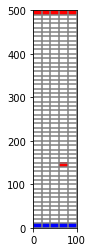

In [181]:
# Plotting
mm = flopy.plot.PlotMapView(model=swt)
plota = mm.plot_grid()
qm = mm.plot_bc(ftype = 'WEL', color = 'red')
qm = mm.plot_ibound()

C:\ProgramData\Anaconda3\lib\site-packages\flopy\plot\plotbase.py:368: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  plotarray[idx] = 1


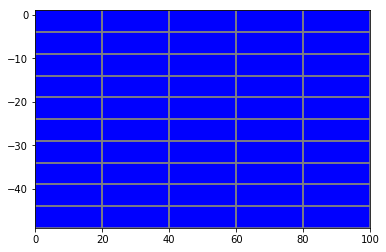

In [182]:
# Plotting
mm2 = flopy.plot.PlotCrossSection(model=swt, line={'row': 0})
plotb = mm2.plot_grid()
qm = mm2.plot_bc(ftype = 'WEL', color = 'blue')

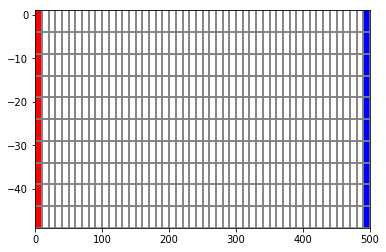

In [183]:
# Plotting
mm2 = flopy.plot.PlotCrossSection(model=swt, line={'column': 0})
plotb = mm2.plot_grid()
qm = mm2.plot_bc(ftype = 'WEL', color = 'red')
qm2 = mm2.plot_ibound()

In [184]:
v = swt.run_model(silent=False, report=True)
for idx in range(-3, 0):
    print(v[1][idx])

FloPy is using the following  executable to run the model: D:\Chelsea\Projects\DelawareStream\Script\Executables\swtv4.exe

                                  SEAWAT Version 4
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 4.00.05 10/19/2012                      

Incorporated MODFLOW Version: 1.18.01 06/20/2008                      
Incorporated MT3DMS  Version: 5.20    10/30/2006                      


 This program is public domain and is released on the
 condition that neither the U.S. Geological Survey nor
 the United States Government may be held liable for any
 damages resulting from their authorized or unauthorized
 use.


 Using NAME file: SeawatBoxModel.nam                                                                                                                                                                                      
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2019/08/05 17:13:05


 STRE

 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.3175E-03  [K,I,J]    5    2    5
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.2320E-03  [K,I,J]    5    2    5
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1189E-04  [K,I,J]    5    2    5

  STRESS PERIOD    1 TIME STEP   23 FROM TIME =   22.000     TO    23.000    

 Transport Step:    1   Step Size:   1.000     Total Elapsed Time:   23.000    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.9301E-02  [K,I,J]    1    6    5
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6079E-02  [K,I,J]    5    2    5
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.6117E-02  [K,I,J]    5    2    5
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.6740E-03  [K,I,J]    5    2    5
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.3584E-04  [K,I,J]    1    3    5

  STRESS PERIOD    1 TIME STEP   24 FROM TIME =   23.000     TO    24.000    

 Transport Step:    1   Step Size:   1.000     Total Elapsed Time:   24.000    
 Outer Iter.  1  Inner Iter.  1:  Max. D

 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.6616E-04  [K,I,J]    6    2    5

  STRESS PERIOD    1 TIME STEP   45 FROM TIME =   44.000     TO    45.000    

 Transport Step:    1   Step Size:   1.000     Total Elapsed Time:   45.000    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.6633E-02  [K,I,J]    1   10    1
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3120E-03  [K,I,J]    6    2    5
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.6551E-04  [K,I,J]    6    2    5

  STRESS PERIOD    1 TIME STEP   46 FROM TIME =   45.000     TO    46.000    

 Transport Step:    1   Step Size:   1.000     Total Elapsed Time:   46.000    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.6566E-02  [K,I,J]    1   10    1
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3009E-03  [K,I,J]    6    2    5
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.6452E-04  [K,I,J]    6    2    5

  STRESS PERIOD    1 TIME STEP   47 FROM TIME =   46.000     TO    47.000    

 Transport Step:    1   Step Size:   1.0

In [185]:
# Post-process the results
import numpy as np
import flopy.utils.binaryfile as bf

# Load data
ucnobj = bf.UcnFile(os.path.join(workspace, 'MT3D001.UCN'), model=swt)
times = ucnobj.get_times()
concentration = ucnobj.get_data(totim=times[-1])
cbbobj = bf.CellBudgetFile(os.path.join(workspace, 'SeawatBoxModel.cbc'))
times = cbbobj.get_times()
qx = cbbobj.get_data(text='flow right face', totim=times[-1])[0]
qz = cbbobj.get_data(text='flow lower face', totim=times[-1])[0]

# Extract the heads
fname = os.path.join(workspace, 'SeawatBoxModel.hds')
headobj = bf.HeadFile(fname)
times = headobj.get_times()
head = headobj.get_data(totim=times[-1])

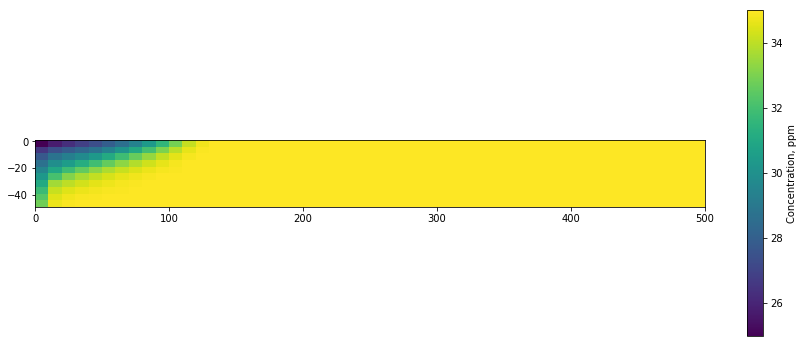

(10, 50, 5)

In [186]:
# Make the plot
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1, aspect='equal')
concplot = ax.imshow(concentration[:, :,2], # aquifer depth, distance from coast, along coast
                     interpolation='nearest', extent=(0, Ly, zbot, ztop)) #left, right, bottom, top

fig.colorbar(concplot, ax=ax, label = "Concentration, ppm", shrink= 0.4)
plt.savefig(os.path.join(workspace, 'SeawatBoxModel.png'))
fig.set_figheight(15)
fig.set_figwidth(15)
plt.show();
#concentration.shape
z.shape

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\contour.py:1243: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


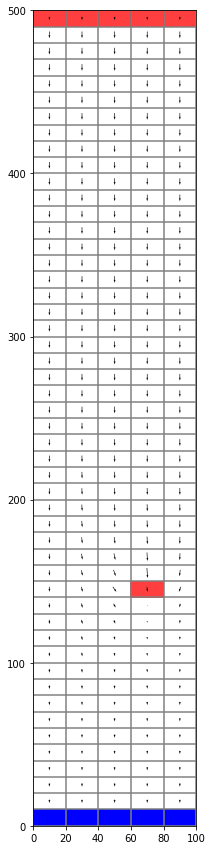

In [187]:
levels = np.linspace(-1,1, 11)

# Extract flow right face and flow front face
frf = cbbobj.get_data(text='FLOW RIGHT FACE', totim=times[-1])[0]
fff = cbbobj.get_data(text='FLOW FRONT FACE', totim=times[-1])[0]

#Create the plot
f = plt.figure()
plt.subplot(1, 1, 1, aspect='equal')
f.set_figheight(15)
f.set_figwidth(15)

modelmap = flopy.plot.PlotMapView(model=swt, layer=0)
qm = modelmap.plot_ibound()
lc = modelmap.plot_grid()
qm = modelmap.plot_bc('WEL', alpha=0.5)
cs = modelmap.contour_array(head, levels=levels)
plt.clabel(cs, inline=1, fontsize=10, fmt='%1.1f')
quiver = modelmap.plot_discharge(frf, fff, head=head)

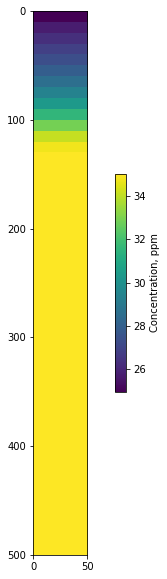

(10, 50, 5)

In [161]:
# Make the plot
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1, aspect='equal')
concplot = ax.imshow(concentration[0, :, :], # aquifer depth, distance from coast, along coast
                     interpolation='nearest', extent=(0, 50, 500, 0)) #left, right, bottom, top


fig.colorbar(concplot, ax=ax, label = "Concentration, ppm", shrink= 0.4)
plt.savefig(os.path.join(workspace, 'SeawatBoxModelOceanFace.png'))
plt.show();
head.shape

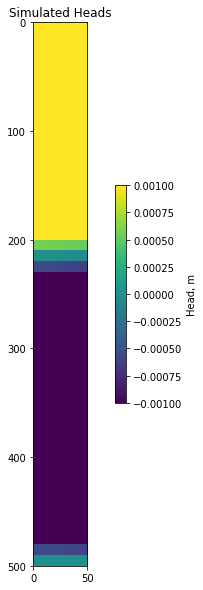

In [162]:
# Make a simple head plot
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1, aspect='equal')# aquifer depth, distance from coast, along coast
im = ax.imshow(head[3, :, :], interpolation='nearest',
               extent=(0, 50, 500, 0), vmin = -0.001, vmax = 0.001) #left, right, bottom, top

ax.set_title('Simulated Heads');
fig.colorbar(im, ax=ax, label = "Head, m", shrink= 0.4)

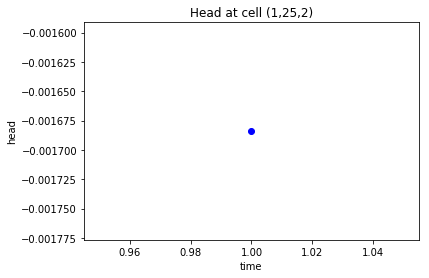

In [146]:
# Plot the head versus time
idx = (0, int(nrow/2) - 1, int(ncol/2) - 1)
ts = headobj.get_ts(idx)
plt.subplot(1, 1, 1)
ttl = 'Head at cell ({0},{1},{2})'.format(idx[0] + 1, idx[1] + 1, idx[2] + 1)
plt.title(ttl)
plt.xlabel('time')
plt.ylabel('head')
plt.plot(ts[:, 0], ts[:, 1], 'bo-')
plt.savefig('SeawatBoxModelHeadvTime.png')